# Import

In [1]:
import os
import glob
import zipfile
import random
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore the warning.
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
from google.colab import drive
import os
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/waste

/gdrive/MyDrive/waste


In [4]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

# Image Visualization & Processing

In [5]:
# Setting up image data generators for training and validation.
# The generators apply a rescale transformation to the images and fill any gaps using the 'reflect' method.

img_train_path = os.path.join("/gdrive/MyDrive/waste/DATASET/TRAIN")
img_test_path = os.path.join("/gdrive/MyDrive/waste/DATASET/TEST")
data_gen = ImageDataGenerator(rescale=1./255, fill_mode='reflect')
val_gen = ImageDataGenerator(rescale=1./255)

train_gen = data_gen.flow_from_directory(img_train_path, target_size=(256,256), batch_size=128)
validation_gen = val_gen.flow_from_directory(img_test_path, target_size=(256,256), batch_size=128)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [6]:
print("Train/Validation indicies: ", train_gen.class_indices)
print("\n0 Stands for Organic \"O\", and 1 stands for Non-Organic \"R\"")

Train/Validation indicies:  {'O': 0, 'R': 1}

0 Stands for Organic "O", and 1 stands for Non-Organic "R"


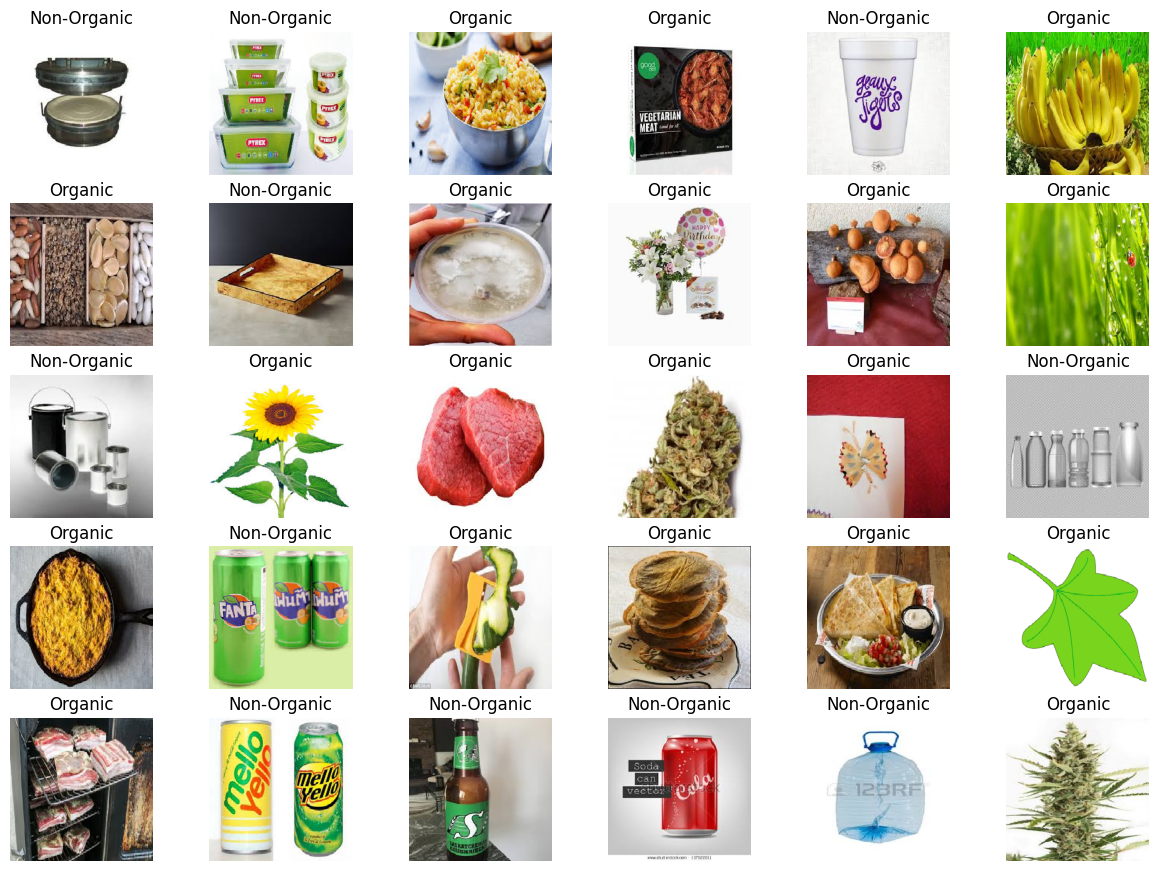

In [7]:
# Plotting images from the train set.

img, _= next(train_gen)
plt.figure(figsize=(15, 13))
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if _[i][1] == 0:
        plt.title("Organic")
    else:
        plt.title("Non-Organic")
    plt.axis("off")
del img
del _

In [8]:
model = tf.keras.Sequential()

# Add convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add fully-connected layers with weight decay
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [9]:
model.compile(optimizer='Nadam',loss='CategoricalCrossentropy', metrics=['accuracy'])

In [10]:
# Setting up early stopping and model checkpointing to ensure we save the best model during training
# The early stopping monitor will stop training if the validation loss does not improve after 5 epochs
# The model checkpoint will save the best model based on the validation loss, and restore the best weights if training is stopped early

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', save_best_only=True)

# Training

In [11]:
# Compiling the model using the Nadam optimizer, categorical cross-entropy loss, and accuracy metric

history = model.fit(train_gen, validation_data=validation_gen, epochs=30, callbacks=[best_model, early_stopping_monitor])

Epoch 1/30
177/177 [==============================] - 121s 592ms/step - loss: 0.6301 - accuracy: 0.7867 - val_loss: 0.4000 - val_accuracy: 0.8770
Epoch 2/30
177/177 [==============================] - 99s 561ms/step - loss: 0.4236 - accuracy: 0.8428 - val_loss: 0.3484 - val_accuracy: 0.8918
Epoch 3/30
177/177 [==============================] - 99s 560ms/step - loss: 0.3791 - accuracy: 0.8589 - val_loss: 0.3694 - val_accuracy: 0.8683
Epoch 4/30
177/177 [==============================] - 104s 585ms/step - loss: 0.3484 - accuracy: 0.8704 - val_loss: 0.3158 - val_accuracy: 0.8910
Epoch 5/30
177/177 [==============================] - 99s 559ms/step - loss: 0.3324 - accuracy: 0.8777 - val_loss: 0.3090 - val_accuracy: 0.8842
Epoch 6/30
177/177 [==============================] - 99s 559ms/step - loss: 0.3173 - accuracy: 0.8833 - val_loss: 0.3492 - val_accuracy: 0.8552
Epoch 7/30
177/177 [==============================] - 102s 573ms/step - loss: 0.3025 - accuracy: 0.8891 - val_loss: 0.2827 - val

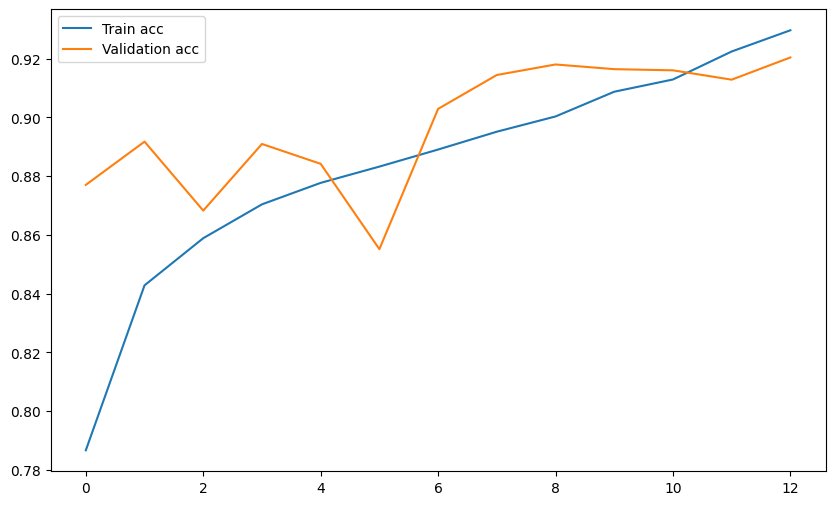

In [12]:
# Plotting the training and validation accuracy over the epochs
# The figure size is set to [10,6] and the accuracy is plotted for both the training and validation sets
# A legend is added to the plot to distinguish between the two sets, and the plot is then displayed using plt.show()

plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

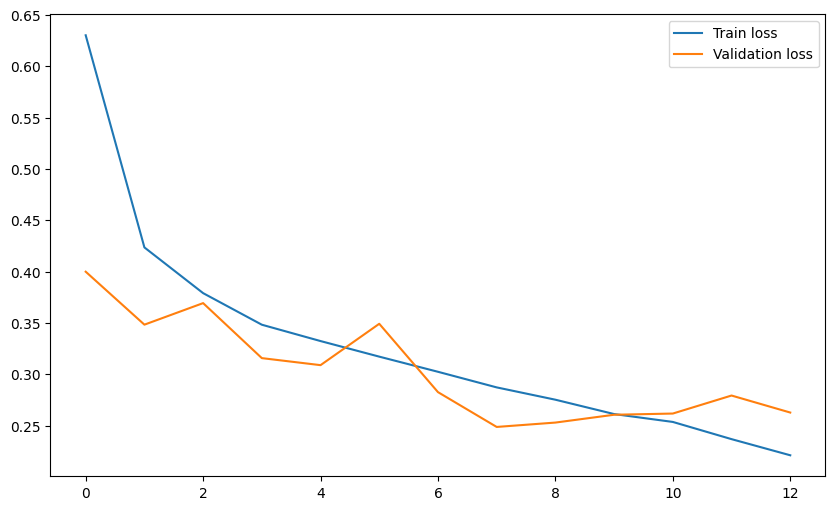

In [13]:
# Plotting the training and validation loss over the epochs
# The figure size is set to (10,6) and the loss is plotted for both the training and validation sets
# A legend is added to the plot to distinguish between the two sets, and the plot is then displayed using plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

# Testing

In [14]:
# Loading the weights of the best model, as determined by the model checkpoint during training
# Evaluating the model on the validation generator, and printing the evaluation metrics

model.load_weights('bestmodel.hdf5')
model.evaluate(validation_gen);

20/20 [==============================] - 9s 463ms/step - loss: 0.2488 - accuracy: 0.9144


In [15]:
# Defining a function to predict the class of an input image using the model
# The function takes an image as input and returns the model's prediction for the class of the image

def predict_func(img):
    result = model.predict(img)
    return result

4/4 [==============================] - 2s 25ms/step


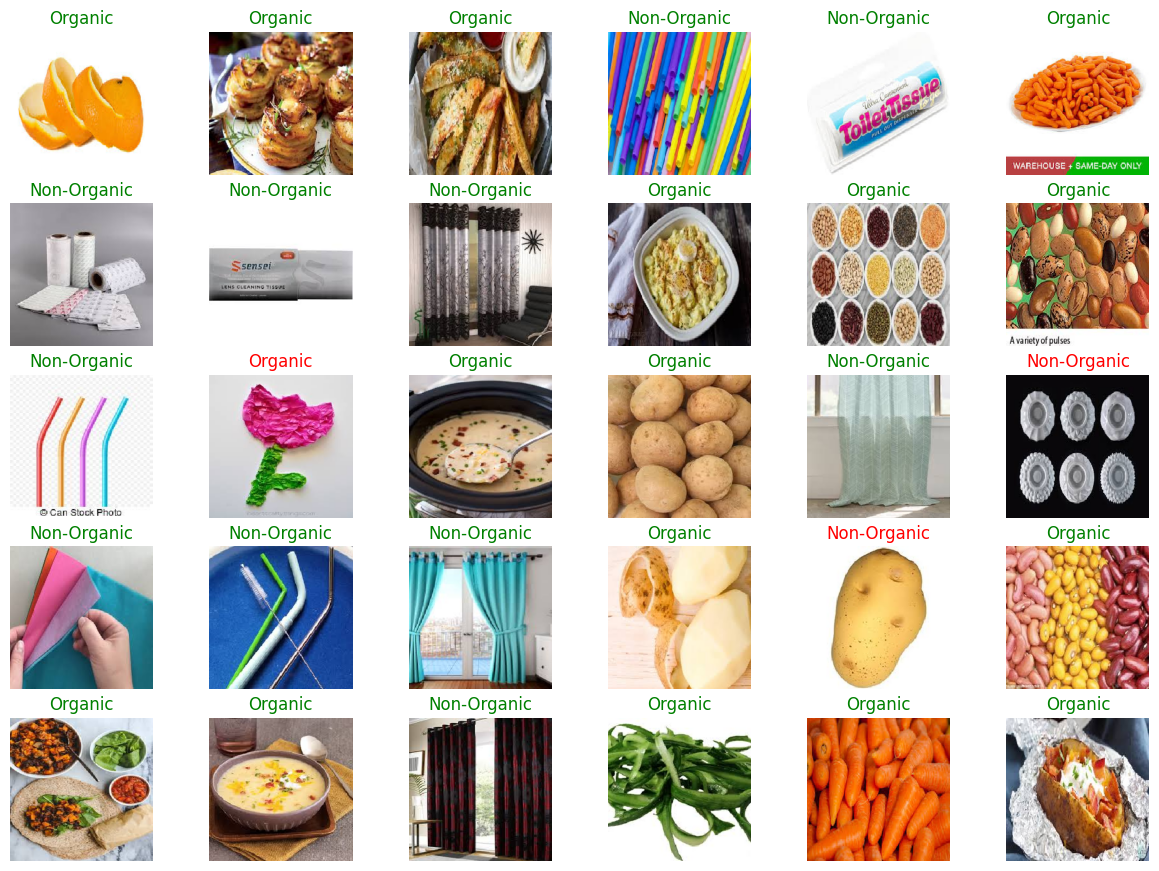

In [16]:
# Visualizing the model's predictions on a batch of validation images
# The figure size is set to (15, 13) and 30 images are plotted in a grid layout
# The model's prediction for each image is obtained using model.predict, and the true label of the image is obtained from the validation generator
# The title of each image shows the model's prediction, and is colored green if the prediction is correct, or red if the prediction is incorrect
# The axis of each image is turned off to focus on the image itself

img, _= next(validation_gen)
plt.figure(figsize=(15, 13))
result = model.predict(img)
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if result[i][1] < 0.5:
        pred = 0
        if pred == _[i][1]:
            plt.title("Organic", color='green')
        else:
            plt.title("Organic", color='red')
    else:
        pred = 1
        if pred == _[i][1]:
            plt.title("Non-Organic", color='green')
        else:
            plt.title("Non-Organic", color='red')
    plt.axis("off")

In [17]:
model.save('model.h5')